In [1]:
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
import glob  # For populating the list of files
from scipy.ndimage import zoom  # For resizing
import re  # For parsing the filenames (to know their modality)

In [2]:
import keras.backend as K
from keras.losses import mse
from keras.layers import Conv3D, Activation, Add, UpSampling3D, Lambda, Dense
from keras.layers import Input, Reshape, Flatten, Dropout, SpatialDropout3D
from keras.optimizers import Adam
from keras.models import Model
try:
    from group_norm import GroupNormalization
except ImportError:
    import urllib.request
    print('Downloading group_norm.py in the current directory...')
    url = 'https://raw.githubusercontent.com/titu1994/Keras-Group-Normalization/master/group_norm.py'
    urllib.request.urlretrieve(url, "group_norm.py")
    from group_norm import GroupNormalization


def green_block(inp, filters, data_format='channels_first', name=None):
    """
    green_block(inp, filters, name=None)
    ------------------------------------
    Implementation of the special residual block used in the paper. The block
    consists of two (GroupNorm --> ReLu --> 3x3x3 non-strided Convolution)
    units, with a residual connection from the input `inp` to the output. Used
    internally in the model. Can be used independently as well.

    Parameters
    ----------
    `inp`: An keras.layers.layer instance, required
        The keras layer just preceding the green block.
    `filters`: integer, required
        No. of filters to use in the 3D convolutional block. The output
        layer of this green block will have this many no. of channels.
    `data_format`: string, optional
        The format of the input data. Must be either 'chanels_first' or
        'channels_last'. Defaults to `channels_first`, as used in the paper.
    `name`: string, optional
        The name to be given to this green block. Defaults to None, in which
        case, keras uses generated names for the involved layers. If a string
        is provided, the names of individual layers are generated by attaching
        a relevant prefix from [GroupNorm_, Res_, Conv3D_, Relu_, ], followed
        by _1 or _2.

    Returns
    -------
    `out`: A keras.layers.Layer instance
        The output of the green block. Has no. of channels equal to `filters`.
        The size of the rest of the dimensions remains same as in `inp`.
    """
    inp_res = Conv3D(
        filters=filters,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format=data_format,
        name=f'Res_{name}' if name else None)(inp)

    # axis=1 for channels_first data format
    # No. of groups = 8, as given in the paper
    x = GroupNormalization(
        groups=8,
        axis=1 if data_format == 'channels_first' else 0,
        name=f'GroupNorm_1_{name}' if name else None)(inp)
    x = Activation('relu', name=f'Relu_1_{name}' if name else None)(x)
    x = Conv3D(
        filters=filters,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format=data_format,
        name=f'Conv3D_1_{name}' if name else None)(x)

    x = GroupNormalization(
        groups=8,
        axis=1 if data_format == 'channels_first' else 0,
        name=f'GroupNorm_2_{name}' if name else None)(x)
    x = Activation('relu', name=f'Relu_2_{name}' if name else None)(x)
    x = Conv3D(
        filters=filters,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format=data_format,
        name=f'Conv3D_2_{name}' if name else None)(x)

    out = Add(name=f'Out_{name}' if name else None)([x, inp_res])
    return out

def dice_coefficient(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[-3,-2,-1])
    dn = K.sum(K.square(y_true) + K.square(y_pred), axis=[-3,-2,-1]) + 1e-8
    return K.mean(2 * intersection / dn, axis=[0,1])


def loss_gt(e=1e-8):
    """
    loss_gt(e=1e-8)
    ------------------------------------------------------
    Since keras does not allow custom loss functions to have arguments
    other than the true and predicted labels, this function acts as a wrapper
    that allows us to implement the custom loss used in the paper. This function
    only calculates - L<dice> term of the following equation. (i.e. GT Decoder part loss)
    
    L = - L<dice> + weight_L2 ∗ L<L2> + weight_KL ∗ L<KL>
    
    Parameters
    ----------
    `e`: Float, optional
        A small epsilon term to add in the denominator to avoid dividing by
        zero and possible gradient explosion.
        
    Returns
    -------
    loss_gt_(y_true, y_pred): A custom keras loss function
        This function takes as input the predicted and ground labels, uses them
        to calculate the dice loss.
        
    """
    def loss_gt_(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[-3,-2,-1])
        dn = K.sum(K.square(y_true) + K.square(y_pred), axis=[-3,-2,-1]) + e
        
        return - K.mean(2 * intersection / dn, axis=[0,1])
    
    return loss_gt_

def loss_gt_(y_true, y_pred, e=1e-8):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[-3,-2,-1])
    dn = K.sum(K.square(y_true) + K.square(y_pred), axis=[-3,-2,-1]) + e
        
    return - K.mean(2 * intersection / dn, axis=[0,1])

def build_model(input_shape=(4, 160, 192, 128), output_channels=3, weight_L2=0.1, weight_KL=0.1, dice_e=1e-8):
    """
    build_model(input_shape=(4, 160, 192, 128), output_channels=3, weight_L2=0.1, weight_KL=0.1)
    -------------------------------------------
    Creates the model used in the BRATS2018 winning solution
    by Myronenko A. (https://arxiv.org/pdf/1810.11654.pdf)

    Parameters
    ----------
    `input_shape`: A 4-tuple, optional.
        Shape of the input image. Must be a 4D image of shape (c, H, W, D),
        where, each of H, W and D are divisible by 2^4, and c is divisible by 4.
        Defaults to the crop size used in the paper, i.e., (4, 160, 192, 128).
    `output_channels`: An integer, optional.
        The no. of channels in the output. Defaults to 3 (BraTS 2018 format).
    `weight_L2`: A real number, optional
        The weight to be given to the L2 loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.
    `weight_KL`: A real number, optional
        The weight to be given to the KL loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.
    `dice_e`: Float, optional
        A small epsilon term to add in the denominator of dice loss to avoid dividing by
        zero and possible gradient explosion. This argument will be passed to loss_gt function.


    Returns
    -------
    `model`: A keras.models.Model instance
        The created model.
    """
    c, H, W, D = input_shape
    assert len(input_shape) == 4, "Input shape must be a 4-tuple"
    assert (c % 4) == 0, "The no. of channels must be divisible by 4"
    assert (H % 16) == 0 and (W % 16) == 0 and (D % 16) == 0, \
        "All the input dimensions must be divisible by 16"


    # -------------------------------------------------------------------------
    # Encoder
    # -------------------------------------------------------------------------

    ## Input Layer
    inp = Input(input_shape)

    ## The Initial Block
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format='channels_first',
        name='Input_x1')(inp)

    ## Dropout (0.2)
    x = SpatialDropout3D(0.2, data_format='channels_first')(x)

    ## Green Block x1 (output filters = 32)
    x1 = green_block(x, 32, name='x1')
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_32')(x1)

    ## Green Block x2 (output filters = 64)
    x = green_block(x, 64, name='Enc_64_1')
    x2 = green_block(x, 64, name='x2')
    x = Conv3D(
        filters=64,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_64')(x2)

    ## Green Blocks x2 (output filters = 128)
    x = green_block(x, 128, name='Enc_128_1')
    x3 = green_block(x, 128, name='x3')
    x = Conv3D(
        filters=128,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_128')(x3)

    ## Green Blocks x4 (output filters = 256)
    x = green_block(x, 256, name='Enc_256_1')
    x = green_block(x, 256, name='Enc_256_2')
    x = green_block(x, 256, name='Enc_256_3')
    x4 = green_block(x, 256, name='x4')

    # -------------------------------------------------------------------------
    # Decoder
    # -------------------------------------------------------------------------

    ## GT (Groud Truth) Part
    # -------------------------------------------------------------------------

    ### Green Block x1 (output filters=128)
    x = Conv3D(
        filters=128,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_128')(x4)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_128')(x)
    x = Add(name='Input_Dec_GT_128')([x, x3])
    x = green_block(x, 128, name='Dec_GT_128')

    ### Green Block x1 (output filters=64)
    x = Conv3D(
        filters=64,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_64')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_64')(x)
    x = Add(name='Input_Dec_GT_64')([x, x2])
    x = green_block(x, 64, name='Dec_GT_64')

    ### Green Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_32')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_32')(x)
    x = Add(name='Input_Dec_GT_32')([x, x1])
    x = green_block(x, 32, name='Dec_GT_32')

    ### Blue Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format='channels_first',
        name='Input_Dec_GT_Output')(x)

    ### Output Block
    out_GT = Conv3D(
        filters=output_channels,  # No. of tumor classes is 3
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        activation='sigmoid',
        name='Dec_GT_Output')(x)

    # Build and Compile the model
    out = out_GT
    model = Model(inp, outputs=[out])  # Create the model
    model.compile(
        optimizer = Adam(lr=1e-6),
        loss=loss_gt_,
        metrics=[dice_coefficient]
    )

    return model


Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\py37\lib\site-packag

In [3]:
t1 = glob.glob(r'C:/Users/gongc/MICCAI_BraTS_2018_Data_Training/*/*/*t1.nii.gz')
t2 = glob.glob(r'C:/Users/gongc/MICCAI_BraTS_2018_Data_Training/*/*/*t2.nii.gz')
flair = glob.glob(r'C:/Users/gongc/MICCAI_BraTS_2018_Data_Training/*/*/*flair.nii.gz')
t1ce = glob.glob(r'C:/Users/gongc/MICCAI_BraTS_2018_Data_Training/*/*/*t1ce.nii.gz')
seg = glob.glob(r'C:/Users/gongc/MICCAI_BraTS_2018_Data_Training/*/*/*seg.nii.gz')

In [4]:
def read_img(img_path):
    """
    Reads a .nii.gz image and returns as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))

In [5]:
pat = re.compile('.*_(\w*)\.nii\.gz')

data_paths = [{
    pat.findall(item)[0]:item
    for item in items
}
for items in list(zip(t1, t2, t1ce, flair, seg))]

In [7]:
input_shape = (4, 80, 112, 80)
output_channels = 3
data = np.empty((len(data_paths[211:284]),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths[211:284]), output_channels) + input_shape[1:], dtype=np.uint8)

In [8]:
data[0].shape

(4, 80, 112, 80)

In [8]:
import cv2

#orig_shape 155,240,240
def crop(img):
# centercrop to (128,176,132)
    return img[11:139,40:216,51:183]

def resize(img, shape, mode='constant', orig_shape=(128, 176, 132)):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1], 
        shape[2]/orig_shape[2]
    )
    
    # Resize to the given shape
    return zoom(img, factors, mode=mode)

def cvimg(img):
    kernel = np.ones((3, 3))
    img_closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
    return img_closed

def preprocess(img, out_shape=None):
    """
    Preprocess the image.
    Just an example, you can add more preprocessing steps if you wish to.
    """
    img = crop(img)
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')
    
    # Normalize the image
    mean = img.mean()
    std = img.std()
    return (img - mean) / std

def preprocess_label(img, out_shape=None, mode='nearest'):
    """
    Separates out the 3 labels from the segmentation provided, namely:
    GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2))
    and the necrotic and non-enhancing tumor core (NCR/NET — label 1)
    """
    img = crop(img)
    
    ncr = img == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
    ed = img == 2  # Peritumoral Edema (ED)
    et = img == 4  # GD-enhancing Tumor (ET)
    
    if out_shape is not None:
        ncr = resize(ncr, out_shape, mode=mode)
        ed = resize(ed, out_shape, mode=mode)
        et = resize(et, out_shape, mode=mode)

    y = np.array([ncr, ed, et], dtype=np.uint8)
    
    for i in range(0,3):
        y[i] = cvimg(y[i])

    return y

In [10]:
import math

# Parameters for the progress bar
for i, imgs in enumerate(data_paths[211:284]):
    try:
        data[i] = np.array([preprocess(read_img(imgs[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
        labels[i] = preprocess_label(read_img(imgs['seg']), input_shape[1:])[None, ...]
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

(4, 80, 112, 80)
0.036621094


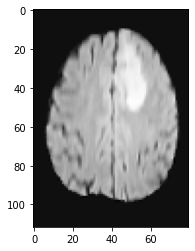

In [17]:
import matplotlib.pyplot as plt
img = data[0]
print(img.shape)
print(img.sum())
plt.imshow(img[3][60], cmap='Greys_r')

(3, 80, 112, 80)
6609


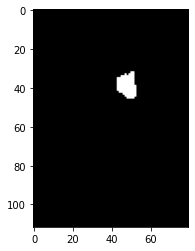

In [16]:
import matplotlib.pyplot as plt
img = labels[0]
print(img.shape)
print(img.sum())
plt.imshow(img[0][60], cmap='Greys_r')

In [12]:
model = build_model(input_shape=input_shape, output_channels=3)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.fit(data, labels, batch_size=1, epochs=200)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
150/150 [==============================] - 136s 908ms/step - loss: -0.0861 - dice_coefficient: 0.0861
Epoch 2/200
150/150 [==============================] - 128s 851ms/step - loss: -0.1877 - dice_coefficient: 0.1877
Epoch 3/200
150/150 [==============================] - 129s 862ms/step - loss: -0.2248 - dice_coefficient: 0.2248
Epoch 4/200
150/150 [==============================] - 129s 858ms/step - loss: -0.2338 - dice_coefficient: 0.2338
Epoch 5/200
150/150 [==============================] - 128s 856ms/step - loss: -0.2573 - dice_coefficient: 0.2573
Epoch 6/200
150/150 [==============================] - 129s 859ms/step - loss: -0.2579 - dice_coefficient: 0.2579
Epoch 7/200
150/150 [==============================] - 129s 858ms/step - loss: -0.2762 - dice_coefficient: 0.2762
Epoch 8/200
150/150 [==============================] - 129s 857ms/step - loss: -0.2827 - dice_coefficient: 0.2827
Epoch 9/200
150/150 [===================

Epoch 70/200
150/150 [==============================] - 128s 852ms/step - loss: -0.5929 - dice_coefficient: 0.5929
Epoch 71/200
150/150 [==============================] - 128s 852ms/step - loss: -0.5954 - dice_coefficient: 0.5954
Epoch 72/200
150/150 [==============================] - 128s 853ms/step - loss: -0.5929 - dice_coefficient: 0.5929
Epoch 73/200
150/150 [==============================] - 128s 853ms/step - loss: -0.5911 - dice_coefficient: 0.5911
Epoch 74/200
150/150 [==============================] - 128s 853ms/step - loss: -0.5946 - dice_coefficient: 0.5946
Epoch 75/200
150/150 [==============================] - 128s 853ms/step - loss: -0.6000 - dice_coefficient: 0.6000
Epoch 76/200
150/150 [==============================] - 128s 854ms/step - loss: -0.6022 - dice_coefficient: 0.6022
Epoch 77/200
150/150 [==============================] - 128s 854ms/step - loss: -0.5984 - dice_coefficient: 0.5984
Epoch 78/200
150/150 [==============================] - 128s 853ms/step - loss: 

In [14]:
model.save('brats2018_model_150data.h5')

In [15]:
input_shape = (4, 80, 112, 80)
output_channels = 3
data = np.empty((len(data_paths[211:284]),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths[211:284]), output_channels) + input_shape[1:], dtype=np.uint8)

In [16]:
# Parameters for the progress bar
for i, imgs in enumerate(data_paths[211:284]):
    try:
        data[i] = np.array([preprocess(read_img(imgs[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
        labels[i] = preprocess_label(read_img(imgs['seg']), input_shape[1:])[None, ...]
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

In [18]:
from keras.models import load_model
model = load_model('brats2018_model_150data.h5', custom_objects={'loss_gt_': loss_gt_, 'dice_coefficient': dice_coefficient})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [19]:
model.fit(data, labels, batch_size=1, epochs=200)

Epoch 1/200
73/73 [==============================] - 71s 971ms/step - loss: -0.3459 - dice_coefficient: 0.3459
Epoch 2/200
73/73 [==============================] - 61s 841ms/step - loss: -0.3969 - dice_coefficient: 0.3969
Epoch 3/200
73/73 [==============================] - 62s 850ms/step - loss: -0.4021 - dice_coefficient: 0.4021
Epoch 4/200
73/73 [==============================] - 62s 856ms/step - loss: -0.4202 - dice_coefficient: 0.4202
Epoch 5/200
73/73 [==============================] - 63s 857ms/step - loss: -0.4137 - dice_coefficient: 0.4137
Epoch 6/200
73/73 [==============================] - 62s 848ms/step - loss: -0.4277 - dice_coefficient: 0.4277
Epoch 7/200
73/73 [==============================] - 62s 847ms/step - loss: -0.4362 - dice_coefficient: 0.4362
Epoch 8/200
73/73 [==============================] - 62s 848ms/step - loss: -0.4457 - dice_coefficient: 0.4457
Epoch 9/200
73/73 [==============================] - 62s 849ms/step - loss: -0.4512 - dice_coefficient: 0.4512
E

73/73 [==============================] - 62s 852ms/step - loss: -0.6331 - dice_coefficient: 0.6331
Epoch 147/200
73/73 [==============================] - 62s 850ms/step - loss: -0.6324 - dice_coefficient: 0.6324
Epoch 148/200
73/73 [==============================] - 62s 850ms/step - loss: -0.6347 - dice_coefficient: 0.6347
Epoch 149/200
73/73 [==============================] - 62s 851ms/step - loss: -0.6352 - dice_coefficient: 0.6352
Epoch 150/200
73/73 [==============================] - 62s 850ms/step - loss: -0.6333 - dice_coefficient: 0.6333
Epoch 151/200
73/73 [==============================] - 62s 850ms/step - loss: -0.6310 - dice_coefficient: 0.6310
Epoch 152/200
73/73 [==============================] - 62s 850ms/step - loss: -0.6363 - dice_coefficient: 0.6363
Epoch 153/200
73/73 [==============================] - 62s 850ms/step - loss: -0.6350 - dice_coefficient: 0.6350
Epoch 154/200
73/73 [==============================] - 62s 850ms/step - loss: -0.6354 - dice_coefficient: 0.63

In [21]:
pred1 = model.predict(data[:1],batch_size=1)

In [22]:
pred1.shape

(1, 3, 80, 112, 80)

(3, 80, 112, 80)
6609


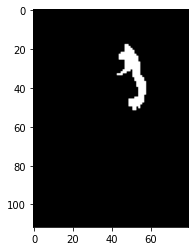

In [37]:
img = labels[0]
print(img.shape)
print(img.sum())
plt.imshow(img[1][60], cmap='Greys_r')

(3, 80, 112, 80)
8310.441


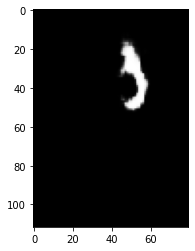

In [38]:
img = pred1[0]
print(img.shape)
print(img.sum())
plt.imshow(img[1][60], cmap='Greys_r')

In [39]:
model.save('D:/brats2018_model_0_150_211_248_data.h5')

In [40]:
len(data_paths)

285

In [6]:
input_shape = (4, 80, 112, 80)
output_channels = 3
data = np.empty((len(data_paths[:285]),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths[:285]), output_channels) + input_shape[1:], dtype=np.uint8)

In [9]:
import math

# Parameters for the progress bar
for i, imgs in enumerate(data_paths[:285]):
    try:
        data[i] = np.array([preprocess(read_img(imgs[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
        labels[i] = preprocess_label(read_img(imgs['seg']), input_shape[1:])[None, ...]
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

In [10]:
labels.shape

(285, 3, 80, 112, 80)

In [17]:
np.unique(labels[0][2])

array([0, 1], dtype=uint8)

In [44]:
model.fit(data, labels, batch_size=1, epochs=200)

Epoch 1/200
285/285 [==============================] - 237s 832ms/step - loss: -0.6215 - dice_coefficient: 0.6215
Epoch 2/200
285/285 [==============================] - 240s 842ms/step - loss: -0.6422 - dice_coefficient: 0.6422
Epoch 3/200
285/285 [==============================] - 241s 846ms/step - loss: -0.6539 - dice_coefficient: 0.6539
Epoch 4/200
285/285 [==============================] - 242s 848ms/step - loss: -0.6626 - dice_coefficient: 0.6626
Epoch 5/200
285/285 [==============================] - 242s 848ms/step - loss: -0.6691 - dice_coefficient: 0.6691
Epoch 6/200
285/285 [==============================] - 242s 849ms/step - loss: -0.6701 - dice_coefficient: 0.6701
Epoch 7/200
285/285 [==============================] - 242s 850ms/step - loss: -0.6738 - dice_coefficient: 0.6738
Epoch 8/200
285/285 [==============================] - 242s 850ms/step - loss: -0.6798 - dice_coefficient: 0.6798
Epoch 9/200
285/285 [==============================] - 242s 850ms/step - loss: -0.6783 -

Epoch 143/200
285/285 [==============================] - 243s 851ms/step - loss: -0.7835 - dice_coefficient: 0.7835
Epoch 144/200
285/285 [==============================] - 242s 851ms/step - loss: -0.7847 - dice_coefficient: 0.7847
Epoch 145/200
285/285 [==============================] - 242s 851ms/step - loss: -0.7845 - dice_coefficient: 0.7845
Epoch 146/200
285/285 [==============================] - 243s 852ms/step - loss: -0.7857 - dice_coefficient: 0.7857
Epoch 147/200
285/285 [==============================] - 243s 852ms/step - loss: -0.7854 - dice_coefficient: 0.7854
Epoch 148/200
285/285 [==============================] - 243s 851ms/step - loss: -0.7856 - dice_coefficient: 0.7856
Epoch 149/200
285/285 [==============================] - 243s 852ms/step - loss: -0.7857 - dice_coefficient: 0.7857
Epoch 150/200
285/285 [==============================] - 243s 851ms/step - loss: -0.7862 - dice_coefficient: 0.7862
Epoch 151/200
285/285 [==============================] - 243s 851ms/step

In [45]:
model.save('D:/brats2018_model_0_284_data.h5')

In [50]:
t1 = glob.glob(r'D:/archive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii')
t2 = glob.glob(r'D:/archive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii')
flair = glob.glob(r'D:/archive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii')
t1ce = glob.glob(r'D:/archive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii')
seg = glob.glob(r'D:/archive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii')

In [52]:
pat = re.compile('.*_(\w*)\.nii')

data_paths = [{
    pat.findall(item)[0]:item
    for item in items
}
for items in list(zip(t1, t2, t1ce, flair, seg))]

In [53]:
input_shape = (4, 80, 112, 80)
output_channels = 3
data = np.empty((len(data_paths[:300]),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths[:300]), output_channels) + input_shape[1:], dtype=np.uint8)

In [54]:
import math

# Parameters for the progress bar
for i, imgs in enumerate(data_paths[:300]):
    try:
        data[i] = np.array([preprocess(read_img(imgs[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
        labels[i] = preprocess_label(read_img(imgs['seg']), input_shape[1:])[None, ...]
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

In [55]:
model.fit(data, labels, batch_size=1, epochs=200)

Epoch 1/200
300/300 [==============================] - 253s 844ms/step - loss: -0.7890 - dice_coefficient: 0.7890
Epoch 2/200
300/300 [==============================] - 257s 856ms/step - loss: -0.7904 - dice_coefficient: 0.7904
Epoch 3/200
300/300 [==============================] - 257s 856ms/step - loss: -0.7958 - dice_coefficient: 0.7958
Epoch 4/200
300/300 [==============================] - 257s 857ms/step - loss: -0.7971 - dice_coefficient: 0.7971
Epoch 5/200
300/300 [==============================] - 257s 857ms/step - loss: -0.8008 - dice_coefficient: 0.8008
Epoch 6/200
300/300 [==============================] - 257s 858ms/step - loss: -0.8001 - dice_coefficient: 0.8001
Epoch 7/200
300/300 [==============================] - 258s 858ms/step - loss: -0.8021 - dice_coefficient: 0.8021
Epoch 8/200
300/300 [==============================] - 258s 859ms/step - loss: -0.8017 - dice_coefficient: 0.8017
Epoch 9/200
300/300 [==============================] - 258s 859ms/step - loss: -0.8043 -

Epoch 143/200
300/300 [==============================] - 255s 851ms/step - loss: -0.8370 - dice_coefficient: 0.8370
Epoch 144/200
300/300 [==============================] - 256s 854ms/step - loss: -0.8398 - dice_coefficient: 0.8398
Epoch 145/200
300/300 [==============================] - 256s 852ms/step - loss: -0.8386 - dice_coefficient: 0.8386
Epoch 146/200
300/300 [==============================] - 256s 852ms/step - loss: -0.8369 - dice_coefficient: 0.8369
Epoch 147/200
300/300 [==============================] - 256s 853ms/step - loss: -0.8381 - dice_coefficient: 0.8381
Epoch 148/200
300/300 [==============================] - 256s 855ms/step - loss: -0.8383 - dice_coefficient: 0.8383
Epoch 149/200
300/300 [==============================] - 257s 856ms/step - loss: -0.8401 - dice_coefficient: 0.8401
Epoch 150/200
300/300 [==============================] - 257s 856ms/step - loss: -0.8383 - dice_coefficient: 0.8383
Epoch 151/200
300/300 [==============================] - 257s 856ms/step

In [56]:
model.save('D:/brats2020_model_0_300_data.h5')

(155, 240, 240)
475747520


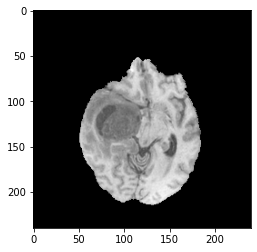

In [58]:
img = read_img(t1[0])
print(img.shape)
print(img.sum())
plt.imshow(img[60], cmap='Greys_r')

(4, 80, 112, 80)
-0.067871094


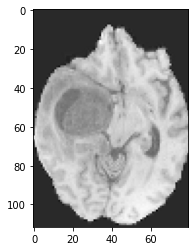

In [72]:
img = data[0]
print(img.shape)
print(img.sum())
plt.imshow(img[0][30], cmap='Greys_r')

(155, 240, 240)
154020821


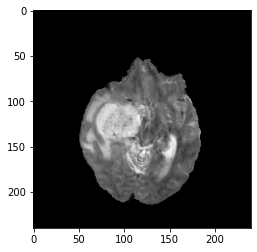

In [59]:
img = read_img(t2[0])
print(img.shape)
print(img.sum())
plt.imshow(img[60], cmap='Greys_r')

(4, 80, 112, 80)
-0.067871094


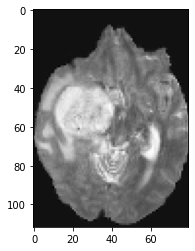

In [73]:
img = data[0]
print(img.shape)
print(img.sum())
plt.imshow(img[1][30], cmap='Greys_r')

(155, 240, 240)
232323666


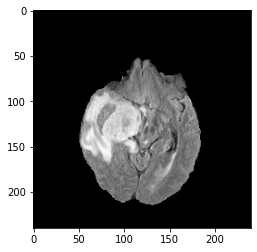

In [60]:
img = read_img(flair[0])
print(img.shape)
print(img.sum())
plt.imshow(img[60], cmap='Greys_r')

(4, 80, 112, 80)
-0.067871094


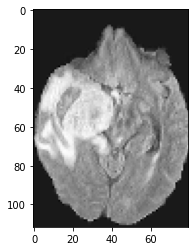

In [75]:
img = data[0]
print(img.shape)
print(img.sum())
plt.imshow(img[3][30], cmap='Greys_r')

(155, 240, 240)
560425174


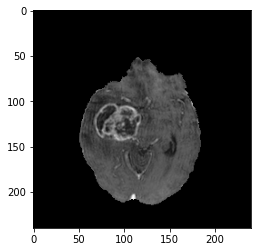

In [61]:
img = read_img(t1ce[0])
print(img.shape)
print(img.sum())
plt.imshow(img[60], cmap='Greys_r')

(4, 80, 112, 80)
-0.067871094


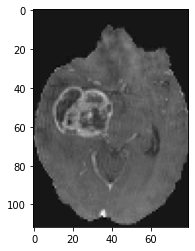

In [76]:
img = data[0]
print(img.shape)
print(img.sum())
plt.imshow(img[2][30], cmap='Greys_r')

(155, 240, 240)
463999


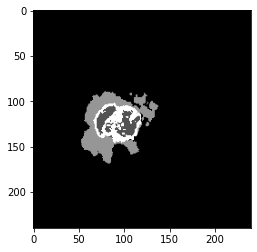

In [78]:
img = read_img(seg[0])
print(img.shape)
print(img.sum())
plt.imshow(img[60], cmap='Greys_r')

(3, 80, 112, 80)
46450


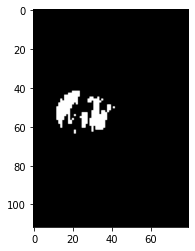

In [79]:
img = labels[0]
print(img.shape)
print(img.sum())
plt.imshow(img[0][30], cmap='Greys_r')

(3, 80, 112, 80)
46450


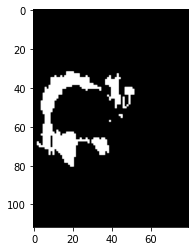

In [80]:
img = labels[0]
print(img.shape)
print(img.sum())
plt.imshow(img[1][30], cmap='Greys_r')

(3, 80, 112, 80)
46450


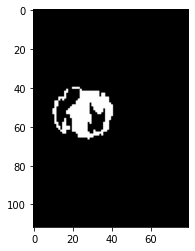

In [81]:
img = labels[0]
print(img.shape)
print(img.sum())
plt.imshow(img[2][30], cmap='Greys_r')

In [46]:
pred2 = model.predict(data[:1],batch_size=1)

(3, 80, 112, 80)
24071


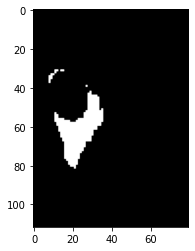

In [48]:
img = labels[0]
print(img.shape)
print(img.sum())
plt.imshow(img[1][40], cmap='Greys_r')

(3, 80, 112, 80)
25518.11


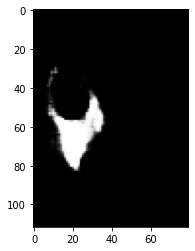

In [49]:
img = pred2[0]
print(img.shape)
print(img.sum())
plt.imshow(img[1][40], cmap='Greys_r')

In [82]:
pred3 = model.predict(data[:50],batch_size=1)

In [91]:
import tensorflow as tf
img_pred3 = tf.cast(pred3, tf.float32)
img_true3 = tf.cast(labels[:50], tf.float32)
result = dice_coefficient(img_true3,img_pred3)

In [98]:
print(result)

Tensor("Mean_3:0", shape=(), dtype=float32)


In [102]:
result.dtype

tf.float32

In [122]:
with tf.Session() as sess:  print(result.eval()) 

0.8642056


In [126]:
sess = tf.Session()
print(sess.run(result))

0.8642056


In [18]:
t1 = glob.glob(r'D:/archive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii')
t2 = glob.glob(r'D:/archive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii')
flair = glob.glob(r'D:/archive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii')
t1ce = glob.glob(r'D:/archive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii')
seg = glob.glob(r'D:/archive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii')

In [19]:
pat = re.compile('.*_(\w*)\.nii')

data_paths = [{
    pat.findall(item)[0]:item
    for item in items
}
for items in list(zip(t1, t2, t1ce, flair, seg))]

In [26]:
from keras.models import load_model
model = load_model('D:/brats2020_model_0_300_data.h5', custom_objects={'loss_gt_': loss_gt_, 'dice_coefficient': dice_coefficient})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [131]:
def precision(y_true, y_pred):
    temp = y_true * y_pred
    TP = np.sum(temp > 0.5)
    TPFP = np.sum(y_pred > 0.5)
    return TP/TPFP

In [132]:
def recall(y_true, y_pred):
    temp = y_true * y_pred
    TP = np.sum(temp > 0.5)
    TPFN = np.sum(y_true == 1)
    return TP/TPFN

In [50]:
input_shape = (4, 80, 112, 80)
output_channels = 3
data = np.empty((len(data_paths[250:367]),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths[250:367]), output_channels) + input_shape[1:], dtype=np.uint8)

In [51]:
import math

# Parameters for the progress bar
for i, imgs in enumerate(data_paths[250:367]):
    try:
        data[i] = np.array([preprocess(read_img(imgs[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
        labels[i] = preprocess_label(read_img(imgs['seg']), input_shape[1:])[None, ...]
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

In [52]:
pred3 = model.predict(data,batch_size=1)

In [133]:
precision(labels, pred3)

0.7543095217684519

In [134]:
recall(labels, pred3)

0.7386824610979023

(4, 80, 112, 80)
-0.122558594


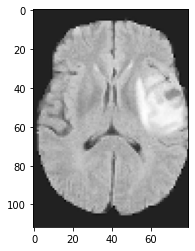

In [150]:
img = data[0]
print(img.shape)
print(img.sum())
plt.imshow(img[3][40], cmap='Greys_r')

(3, 80, 112, 80)
17526


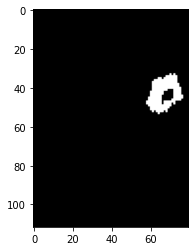

In [153]:
img = labels[0]
print(img.shape)
print(img.sum())
plt.imshow(img[2][40], cmap='Greys_r')

(3, 80, 112, 80)
17987.078


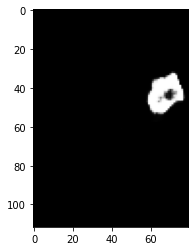

In [156]:
img = pred3[0]
print(img.shape)
print(img.sum())
plt.imshow(img[2][40], cmap='Greys_r')

In [81]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [67]:
df = pandas.read_csv('D:/archive/TRAINING1.csv',header=None)

In [79]:
loss_data = df[0].values

In [86]:
epochs = np.arange(1,201)

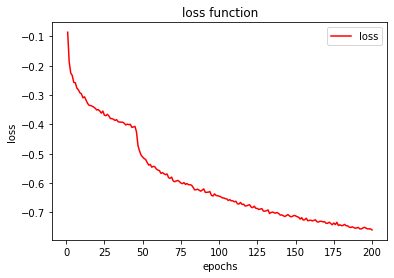

In [88]:
plt.plot(epochs,loss_data,color='r',label='loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("loss function")
plt.legend()
plt.show()

In [89]:
df2 = pandas.read_csv('D:/archive/TRAINING2.csv',header=None)

In [91]:
loss_data2 = df2[0].values

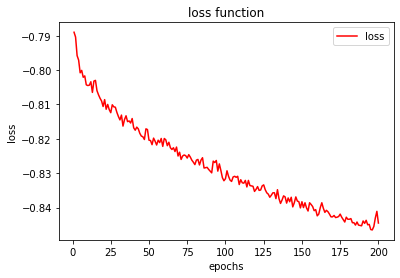

In [92]:
plt.plot(epochs,loss_data2,color='r',label='loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("loss function")
plt.legend()
plt.show()